In [1]:
import pandas as pd
import numpy as np
from graph_data import GraphData
from IPython.display import display

from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
from dtaidistance import clustering
from vega import VegaLite
from vega import utils

# import matplotlib.pyplot as plt 


In [4]:

# path = "/home/vast/MC1/data/"
path = "../data/"

nodes_file_template = "CGCS-Template-NodeTypes.csv"
edges_file_template = "CGCS-Template"

graphs={}

graph = GraphData()
graph.read_data(nodes_file=nodes_file_template, edges_file=edges_file_template+".csv", path=path, path_nodes=path)
                                           
graphs[edges_file_template] = graph

stList = graph.edges.stType.unique()

nodes_file = "CGCS-GraphData-NodeTypes.csv"
graph_names = ["Q1-Graph1", "Q1-Graph2", "Q1-Graph3", "Q1-Graph4", "Q1-Graph5"]

for name in graph_names:
    graph = GraphData()
    graph.read_data(nodes_file=nodes_file, edges_file=name+".csv", path=path, path_nodes=path, stList=stList)
    graphs[name] = graph
    

In [5]:
graphs[edges_file_template].edges.dtypes

Source                     object
eType                      object
Target                     object
Time               datetime64[ns]
Weight                      int64
SourceLocation              int32
TargetLocation              int32
SourceLatitude            float64
SourceLongitude           float64
TargetLatitude            float64
TargetLongitude           float64
SourceType                 object
TargetType                 object
stType                     object
SumWeight                   int64
dtype: object

In [6]:
sc_types = ['Email', 'Phone', 'Buy', 'Sell', 'Travels-to']

In [7]:
def layer_nodes(field_, field, title, sort_field, types):
    if field_ == "Source":
        legend = True
    elif field_ == "Target":
        legend = False
        
    return {
            "mark":{
                "type":"circle",
            },
            "encoding":{
                "y":{
                    "field": field,
                    "type":"ordinal",
                    "axis":{
                        "title": title, 
                        "ticks": False,
                        "offset": 5,
                        "domain": False,
                        "grid": True,
                        "gridDash": {
                            "value": [2,2]
                        },  
                        "labelFontSize": 7,
                        "orient": "left",
                        "titleFontWeight": 300
                    },
                    "sort": {
                        "field": sort_field
                    }
                },
                "color": {
                    "field": "eType",
                    "type": "nominal",
                    "scale": {
                        "domain": types,
                    },
                    "legend": legend
                },
                "tooltip": {
                    "field": field,
                    "type": "nominal"
                }
            }
        }

def layer_rules(field, y2_value):
    return {
                "mark":{
                    "type":"rule",
                    "strokeWidth": 0.5
                },
                "encoding":{
                    "y":{
                        "field": field,
                        "type": "nominal",
                        "sort": {
                            "field": "TargetType"
                        }
                    },
                    "y2":{
                        "value": y2_value
                    },
                    "color": {"value": "#777"}
                }
            }

def area_chart(aggregate_time, reverse):
    if reverse:
        orient = "top"
    else:
        orient = "bottom"
    return {
                "width": 800,
                "height": 20,
                "title": "",
                "data": {
                    'values': aggregate_time
                },
                "mark":{
                        "type":"area", 
                        "color": "#CCCCCC",
                        "interpolate": "monotone",
                    },   
                "encoding":{
                    "x":{
                        "field":"Time",
                        "type":"temporal",
                        "axis": {
                            "title":"",
                            "grid": False,
                            "domain": True, 
                            "domainWidth": 0.3,
                            "orient": orient, 
                            "ticks": False,
                            "labelAlign": "right",
                            "labels": False
                        },
                        "scale": {
                            "domain": [
                                {"year": 2025, "month": 1}, 
                                {"year": 2025, "month": 12}
                            ]
                        }
                    },   
                    "y":{
                            "field":"0",
                            "type": "quantitative",
                            "axis":{
                                "title":"", 
                                "grid": False, 
                                "domain": False, 
                                "orient": "right", 
                                "tickCount": 1
                            },  
                        "scale": {
                            "reverse": reverse
                        }
                        },
                }
            }


def chart_nodes(data, types, field_, field=None):
    if field is None:
        field = field_
        
    if field_ == "Source":
        title = "source"
        sort_field = "TargetType"
        y2_value = "height"
        
    elif field_ == "Target":
        title = "target"
        y2_value = 0
        sort_field = "TargetType"
        
    return {
        "data": {
            'values': data
        },
        "spacing": 0,
        "bounds": "flush",
#         "height": 300,
        "hconcat": [{
            "width": 800,
#             "height": 100,
            "height": {'step': 7},
            "encoding":{
                "x":{
                    "field":"Time",
                    "type":"temporal",
                    "axis": None,   
                    "scale": {
                        "domain": [{"year": 2025, "month": 1}, {"year": 2025, "month": 12}]
                    }
                }
            },
            "layer":[
                layer_nodes(field_, field, title, sort_field, types),
                layer_rules(field, y2_value)
            ],
        },
        {
            "width": 50,
#             "height": 100,
            "height": {'step': 7},
            "mark": "bar",
            "encoding":{
                "x":{
                    "aggregate": "count",
                    "title": "",
                    "type":"quantitative"
                },
                "y":{
                    "field": field,
                    "type":"ordinal",
                    "axis": None,
                    "sort": {
                        "field": sort_field
                    }
                },
                 "color": {
                    "field": "eType",
                    "type": "nominal",
                    "scale": {
                        "domain": types,
                    },
                    "legend": False
                },
            },
        }
        ]
    }

def chart_location(data, field):
    return{
                "width": 800,
                "height": 5,
                "title": "",
                "data": {
                    'values': data
                },
                "mark":{
                    "type":"point"
                }, 
                "encoding":{
                    "x":{
                        "field":"Time",
                        "type":"temporal",
                        "axis": None,   
                        "scale": {
                            "domain": [{"year": 2025, "month": 1}, {"year": 2025, "month": 12}]
                        }
                    },
                    "color": {
                        "field": field,
                        "type": "quantitative",
                        "scale":{ "scheme": "category20b" },
                         "legend": None
                    },
                }
                
            }


In [8]:


def time_chart(title, 
               data_node_source, 
               aggregate_time_source,
               data_node_target, 
               aggregate_time_target,
               types, aggregated=None):
    field_agg = None
    if aggregated:
        field_agg = "eType"
        
    return VegaLite({
        "title": {
            "text": title,
            "fontWeight":200
        },
        "spacing": 0,
        "padding": 0,
        "vconcat": [
            chart_nodes(data_node_source, types, "Source", field_agg), 
            area_chart(aggregate_time_source, False),
#             {
#                 "width": 800,
#                 "height": 5,
#                 "title": "",
#                 "data": {
#                     'values': data_node_target
#                 },
#                 "mark":{
#                     "type":"point"
#                 }, 
#                 "encoding":{
#                     "x":{
#                         "field":"Time",
#                         "type":"temporal",
#                         "axis": None,   
#                         "scale": {
#                             "domain": [{"year": 2025, "month": 1}, {"year": 2025, "month": 12}]
#                         }
#                     },
#                     "color": {
#                         "field": "SourceLocation",
#                         "type": "quantitative",
#                         "scale":{ "scheme": "category20b" },
#                          "legend": None
#                     },
#                 }
                
#             },
#             {
#                 "width": 800,
#                 "height": 5,
#                 "title": "",
#                 "data": {
#                     'values': data_node_target
#                 },
#                 "mark":{
#                     "type":"point"
#                 }, 
#                 "encoding":{
#                     "x":{
#                         "field":"Time",
#                         "type":"temporal",
#                         "axis": None,   
#                         "scale": {
#                             "domain": [{"year": 2025, "month": 1}, {"year": 2025, "month": 12}]
#                         }
#                     },
#                     "color": {
#                         "field": "TargetLocation",
#                         "type": "quantitative",
#                         "scale":{ "scheme": "category20b" },
# #                          "legend": None
#                     },
#                 }
                
#             },
            area_chart(aggregate_time_target, True),
            chart_nodes(data_node_target, types, "Target", field_agg), 
      ],
        "config": {
            "style": {
                "cell": {
                    "stroke": "transparent"
                },
            },
            "autosize": "pad",
            "padding": 0
        }
    })

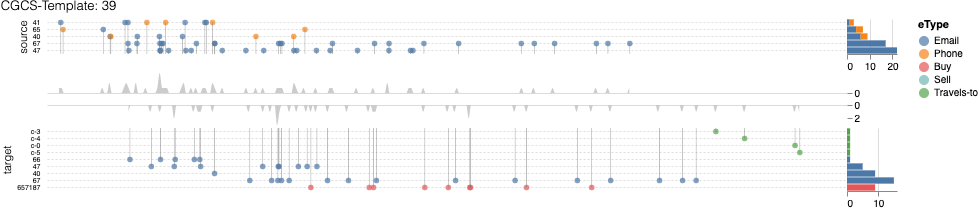

In [14]:
graph_name = "CGCS-Template"
node_id = '39'

mask =  graphs[graph_name].edges_no_financial.eType!='Author-of'

group_by_source = graphs[graph_name].edges_no_financial[mask].groupby('Source')
df_node_source = group_by_source.get_group(node_id)
count_time_source = df_node_source[["Time"]].resample('D', on='Time').agg('size').reset_index()


group_by_target = graphs[graph_name].edges_no_financial[mask].groupby('Target')
df_node_target = group_by_target.get_group(node_id)
count_time_target = df_node_target[["Time"]].resample('D', on='Time').agg('size').reset_index()


data_node_source = utils.sanitize_dataframe(df_node_source).to_dict(orient='records')
data_node_target = utils.sanitize_dataframe(df_node_target).to_dict(orient='records')

aggregate_source = utils.sanitize_dataframe(count_time_source).to_dict(orient='records')
aggregate_target = utils.sanitize_dataframe(count_time_target).to_dict(orient='records')

time_chart(graph_name + ": "+ node_id, 
           data_node_target, aggregate_target, 
            data_node_source, aggregate_source, 
           sc_types, aggregated=False)

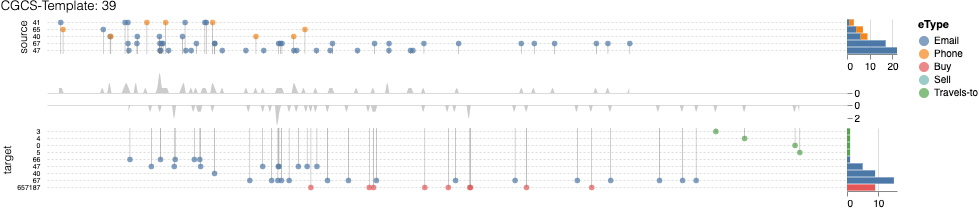

In [9]:
time_chart(graph_name + ": "+ node_id, 
           data_node_target, aggregate_target, 
            data_node_source, aggregate_source, 
           sc_types, aggregated=False)

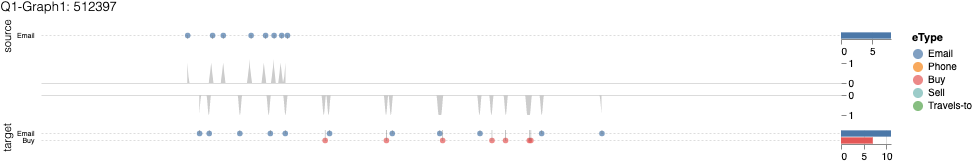

In [11]:
graph_name = "Q1-Graph1"
node_id = '512397'

mask =  graphs[graph_name].edges_no_financial.eType!='Author-of'

group_by_source = graphs[graph_name].edges_no_financial[mask].groupby('Source')
df_node_source = group_by_source.get_group(node_id)
count_time_source = df_node_source[["Time"]].resample('D', on='Time').agg('size').reset_index()


group_by_target = graphs[graph_name].edges_no_financial[mask].groupby('Target')
df_node_target = group_by_target.get_group(node_id)
count_time_target = df_node_target[["Time"]].resample('D', on='Time').agg('size').reset_index()


data_node_source = utils.sanitize_dataframe(df_node_source).to_dict(orient='records')
data_node_target = utils.sanitize_dataframe(df_node_target).to_dict(orient='records')

aggregate_source = utils.sanitize_dataframe(count_time_source).to_dict(orient='records')
aggregate_target = utils.sanitize_dataframe(count_time_target).to_dict(orient='records')

time_chart(graph_name + ": "+ node_id, 
           data_node_target, aggregate_target, 
            data_node_source, aggregate_source, 
           sc_types, aggregated=True)

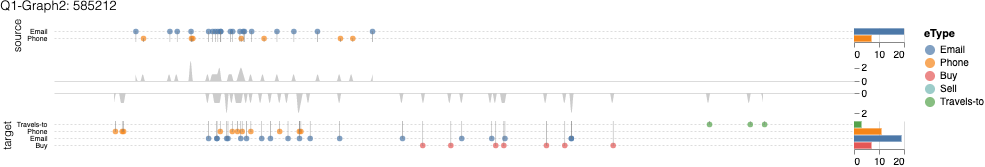

In [12]:
graph_name = "Q1-Graph2"
node_id = '585212'
mask =  graphs[graph_name].edges_no_financial.eType!='Author-of'

group_by_source = graphs[graph_name].edges_no_financial[mask].groupby('Source')
df_node_source = group_by_source.get_group(node_id)
count_time_source = df_node_source[["Time"]].resample('D', on='Time').agg('size').reset_index()


group_by_target = graphs[graph_name].edges_no_financial[mask].groupby('Target')
df_node_target = group_by_target.get_group(node_id)
count_time_target = df_node_target[["Time"]].resample('D', on='Time').agg('size').reset_index()


data_node_source = utils.sanitize_dataframe(df_node_source).to_dict(orient='records')
data_node_target = utils.sanitize_dataframe(df_node_target).to_dict(orient='records')

aggregate_source = utils.sanitize_dataframe(count_time_source).to_dict(orient='records')
aggregate_target = utils.sanitize_dataframe(count_time_target).to_dict(orient='records')

time_chart(graph_name + ": "+ node_id, 
           data_node_target, aggregate_target, 
            data_node_source, aggregate_source, 
           sc_types, aggregated=True)

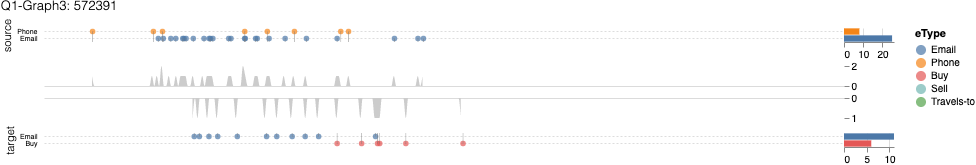

In [13]:

graph_name = "Q1-Graph3"
node_id = '572391'

mask =  graphs[graph_name].edges_no_financial.eType!='Author-of'

group_by_source = graphs[graph_name].edges_no_financial[mask].groupby('Source')
df_node_source = group_by_source.get_group(node_id)
count_time_source = df_node_source[["Time"]].resample('D', on='Time').agg('size').reset_index()


group_by_target = graphs[graph_name].edges_no_financial[mask].groupby('Target')
df_node_target = group_by_target.get_group(node_id)
count_time_target = df_node_target[["Time"]].resample('D', on='Time').agg('size').reset_index()


data_node_source = utils.sanitize_dataframe(df_node_source).to_dict(orient='records')
data_node_target = utils.sanitize_dataframe(df_node_target).to_dict(orient='records')

aggregate_source = utils.sanitize_dataframe(count_time_source).to_dict(orient='records')
aggregate_target = utils.sanitize_dataframe(count_time_target).to_dict(orient='records')

time_chart(graph_name + ": "+ node_id, 
           data_node_target, aggregate_target, 
            data_node_source, aggregate_source, 
           sc_types, aggregated=True)

In [ ]:
#             {
#                 "width": 800,
#                 "height": 20,
#                 "title": "",
#                 "data": {
#                     'values': aggregate_time_source
#                 },
#                 "mark":{
#                         "type":"area", 
#                         "color": "#CCCCCC",
#                         "interpolate": "monotone",
#                     },
#                 "encoding":{
#                     "x":{
#                         "field":"Time",
#                         "type":"temporal",
#                         "axis":{
#                             "title":"",
#                             "grid": False,
#                             "domain": True, 
#                             "domainWidth": 0.3,
#                             "tickCount": 1,
#                             "labelAlign": "right"
#                         },
#                         "scale": {
#                             "domain": [
#                                 {"year": 2025, "month": 1}, 
#                                 {"year": 2025, "month": 12}
#                             ]
#                         }
#                     },   
#                     "y":{
#                             "field":"0",
#                             "type": "quantitative",
#                             "axis":{
#                                 "title":"", 
#                                 "grid": False, 
#                                 "domain": False, 
#                                 "orient": "right", 
#                                 "tickCount": 1
#                             },  
#                         },
#                 }
#             },
#             {
#                 "width": 800,
#                 "height": 5,
#                 "title": "",
#                 "data": {
#                     'values': data_node_target
#                 },
#                 "mark":{
#                     "type":"point"
#                 }, 
#                 "encoding":{
#                     "x":{
#                         "field":"Time",
#                         "type":"temporal",
#                         "axis": None,   
#                         "scale": {
#                             "domain": [{"year": 2025, "month": 1}, {"year": 2025, "month": 12}]
#                         }
#                     },
#                     "color": {
#                         "field": "SourceLocation",
#                         "type": "quantitative",
#                         "scale":{ "scheme": "category20b" },
#                          "legend": None
#                     },
#                 }
                
#             },